In [1]:
import pyro
import pyro.distributions as dist
import torch
import matplotlib.pyplot as plt
import numpy
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import model_selection
import pyro.distributions as pdist
import torch.distributions as tdist
import torch.nn as tnn
import pyro.nn as pnn
import arviz

/Users/alexandroskyriakopoulos/anaconda3/envs/py313/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def gmm_model(n_samples):
    # Component weights (mixing coefficients)
    mixing_coeffs = torch.tensor([0.5, 0.5])

    # Means and covariance matrices
    means = torch.tensor([[1.0, 1.0], [3.0, 5.0]])  #[mu1, mu2]
    print(mixing_coeffs)
    cov_matrix = torch.eye(2)  # Identity matrix
    print(cov_matrix)
    # Plate for generating n_samples
    with pyro.plate("data", n_samples):
        # Sampling from categorical distribution (select a component)
        component = pyro.sample("component", dist.Categorical(mixing_coeffs))
        print(component)
        # Conditional Gaussian sampling based on component
        sampled_data = pyro.sample(
            "obs",
            dist.MultivariateNormal(means[component], cov_matrix)
        )
        print(sampled_data)
    return sampled_data

# Generate 500 samples
samples = gmm_model(500)

tensor([0.5000, 0.5000])
tensor([[1., 0.],
        [0., 1.]])
tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,

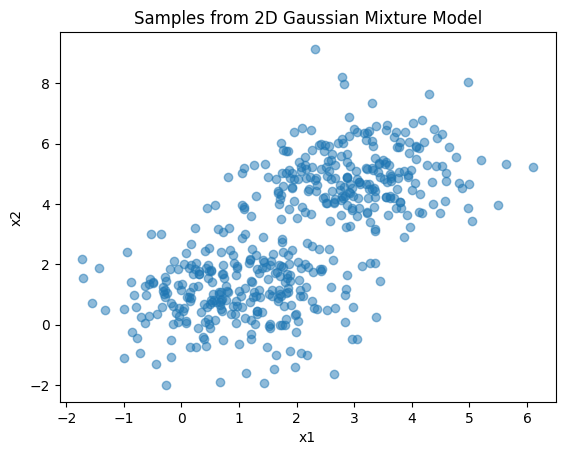

In [3]:
# Plot the samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Samples from 2D Gaussian Mixture Model")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Switch to NUTS

In [4]:
seed_value = 42  # Replace with your desired seed value
torch.manual_seed(seed_value)
pyro.set_rng_seed(seed_value)
numpy.random.seed(seed_value)

# MAP or diagonal normal?
MAP=True
if MAP:
  MAXIT=2000 # SVI iterations
  REPORT=200 # Plot ELBO each time after this amount of SVI iterations
else:
  MAXIT=100000
  REPORT=1000

# Number of samples used in prediction
S=500

In [5]:
def accuracy(pred, data):
  """
  Calculate accuracy of predicted labels (integers).

  pred: predictions, tensor[sample_index, chain_index, data_index, logits]
  data: actual data (digit), tensor[data_index]

  Prediction is taken as most common predicted value.
  Returns accuracy (#correct/#total).
  """
  n=data.shape[0]
  correct=0
  total=0
  for i in range(0, n):
      # Get most common prediction value from logits
      pred_i=int(torch.argmax(torch.sum(pred[:,0,i,:],0)))
      # Compare prediction with data
      if int(data[i])==int(pred_i):
          correct+=1.0
      total+=1.0
  # Return fractional accuracy
  return correct/total

In [6]:
# Iris data set
Dx=4 # Input vector dim
Dy=3 # Number of labels

iris=sklearn.datasets.load_iris()
x_all=torch.tensor(iris.data, dtype=torch.float) # Input vector (4D)
y_all=torch.tensor(iris.target, dtype=torch.int) # Label(3 classes)

# Make training and test set
x, x_test, y, y_test = sklearn.model_selection.train_test_split(
    x_all, y_all, test_size=0.33, random_state=42)

print("Data set iris test set sizes: %i, %i." % (x.shape[0], x_test.shape[0]))

Data set iris test set sizes: 100, 50.


In [7]:
class Model:
    def __init__(self, x_dim=4, y_dim=3, h_dim=5):
        self.x_dim=x_dim
        self.y_dim=y_dim
        self.h_dim=h_dim

    def __call__(self, x, y=None):
        """
        We need None for predictive
        """
        x_dim=self.x_dim
        y_dim=self.y_dim
        h_dim=self.h_dim
        # Number of observations
        n=x.shape[0]
        # standard deviation of Normals
        sd=1 # EXERCISE: 100->1
        # Layer 1
        w1=pyro.sample("w1", pdist.Normal(0, sd).expand([x_dim, h_dim]).to_event(2))
        b1=pyro.sample("b1", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 2 # EXERCISE: added layer
        w2=pyro.sample("w2", pdist.Normal(0, sd).expand([h_dim, h_dim]).to_event(2))
        b2=pyro.sample("b2", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 3
        w3=pyro.sample("w3", pdist.Normal(0, sd).expand([h_dim, y_dim]).to_event(2))
        b3=pyro.sample("b3", pdist.Normal(0, sd).expand([y_dim]).to_event(1))
        # NN
        h1=torch.tanh((x @ w1) + b1)
        h2=torch.tanh((h1 @ w2) + b2) # EXERCISE: added layer
        logits=(h2 @ w3 + b3)
        # Save deterministc variable (logits) in trace
        pyro.deterministic("logits", logits)
        # Categorical likelihood
        with pyro.plate("labels", n):
            obs=pyro.sample("obs", pdist.Categorical(logits=logits), obs=y)

In [8]:
# Instantiate the Model object
model=Model()

if MAP:
    # MAP estimate of model parameter (here SVI boild down to simple gradient descent)
    guide=pyro.infer.autoguide.AutoDelta(model)
else:
    # Variational estimate of model parameters using diagonal normal (SVI)
    guide=pyro.infer.autoguide.AutoDiagonalNormal(model)

# Optimizer
adam=pyro.optim.Adam({"lr": 0.01})
# SVI
svi=pyro.infer.SVI(model, guide, adam, loss=pyro.infer.Trace_ELBO())

# Clear any previously used parameters
pyro.clear_param_store()

# Optimize the ELBO
elbo=[]
for j in range(0, MAXIT):
    loss=svi.step(x, y)
    elbo.append(loss)
    if j%REPORT==0:
        print("[Iteration %04d] loss: %.4f" % (j, loss))


[Iteration 0000] loss: 188.0556
[Iteration 0200] loss: 88.5219
[Iteration 0400] loss: 87.6917
[Iteration 0600] loss: 87.5640
[Iteration 0800] loss: 87.5460
[Iteration 1000] loss: 87.5454
[Iteration 1200] loss: 87.5479
[Iteration 1400] loss: 87.6527
[Iteration 1600] loss: 87.5408
[Iteration 1800] loss: 87.5406


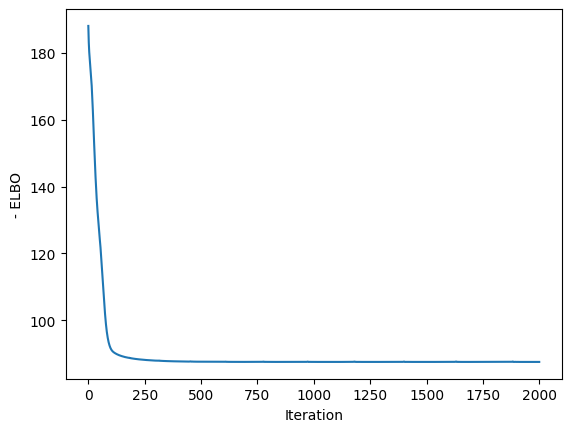

In [9]:
# ELBO vs. iteration plot
plt.xlabel("Iteration")
plt.ylabel("- ELBO")
plt.plot(elbo)

In [10]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDelta.w1 Parameter containing:
tensor([[-0.2765,  0.2770,  0.1315, -0.0905, -0.0906],
        [-0.5053,  0.5062,  0.2951, -0.3772, -0.3774],
        [ 0.5032, -0.5040, -0.3144,  0.6117,  0.6120],
        [ 0.8447, -0.8461, -0.4528,  0.2644,  0.2644]], requires_grad=True)
AutoDelta.b1 Parameter containing:
tensor([-0.6339,  0.6350,  0.2953, -0.0600, -0.0600], requires_grad=True)
AutoDelta.w2 Parameter containing:
tensor([[ 0.1395,  0.8130, -0.1391, -0.8126,  0.8132],
        [-0.1389, -0.8143,  0.1386,  0.8141, -0.8144],
        [-0.3351, -0.4399,  0.3375,  0.4389, -0.4393],
        [ 0.7146, -0.0385, -0.7144,  0.0384, -0.0385],
        [ 0.7153, -0.0386, -0.7146,  0.0385, -0.0386]], requires_grad=True)
AutoDelta.b2 Parameter containing:
tensor([ 0.1218, -0.1285, -0.1222,  0.1282, -0.1284], requires_grad=True)
AutoDelta.w3 Parameter containing:
tensor([[-1.3203,  0.9797,  0.3405],
        [-0.4262, -0.7263,  1.1524],
        [ 1.3203, -0.9798, -0.3405],
        [ 0.4264,  0.7256, -1

In [11]:
guide.requires_grad_(False)

posterior_predictive=pyro.infer.Predictive(model, guide=guide, num_samples=S, return_sites=["logits"])(
x_test, None
)

In [12]:
# Print accuracy
logits=posterior_predictive['logits']
print("Shape of posterior preditive for y (logits):", logits.shape)
print("Success: %.2f" % accuracy(logits, y_test))

Shape of posterior preditive for y (logits): torch.Size([500, 1, 50, 3])
Success: 0.98


In [13]:
# Clear any previously used parameters
pyro.clear_param_store()

In [14]:
# Run NUTS Sampling
print("Running NUTS Sampling...")
nuts_kernel = pyro.infer.NUTS(model, jit_compile=True)
mcmc = pyro.infer.MCMC(
    nuts_kernel, 
    num_samples=500,  # Number of samples to draw
    warmup_steps=100,  # Number of warm-up (burn-in) steps
    num_chains=1       # Single chain
)
mcmc.run(x, y)

# Extract Posterior Samples
posterior_samples = mcmc.get_samples()

predictive = pyro.infer.Predictive(
    model, 
    posterior_samples=posterior_samples,  # Use samples from NUTS
    num_samples=500,                      # Number of posterior predictive samples
    return_sites=["logits"]               # Include model's logits in the output
)
posterior_predictive = predictive(x_test, None)

Running NUTS Sampling...


Warmup:   0%|          | 0/600 [00:00, ?it/s]/Users/alexandroskyriakopoulos/anaconda3/envs/py313/lib/python3.13/site-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 600/600 [02:52,  3.47it/s, step size=7.67e-03, acc. prob=0.968]


In [15]:
logits=posterior_predictive['logits']
print("Shape of posterior preditive for y (logits):", logits.shape)
print("Success: %.2f" % accuracy(logits, y_test))

Shape of posterior preditive for y (logits): torch.Size([500, 1, 50, 3])
Success: 0.98


/Users/alexandroskyriakopoulos/anaconda3/envs/py313/lib/python3.13/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


------------------------------Summary Statistics:-----------------------------
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b1[0]    -0.121  1.042  -1.951    1.782      0.071    0.050     219.0   
b1[1]     0.047  1.085  -2.158    1.960      0.109    0.078     102.0   
b1[2]    -0.037  1.112  -2.201    1.980      0.099    0.070     124.0   
b1[3]    -0.014  1.016  -1.859    1.959      0.060    0.053     293.0   
b1[4]    -0.008  1.135  -1.906    2.201      0.136    0.097      74.0   
...         ...    ...     ...      ...        ...      ...       ...   
w3[3, 1] -0.191  1.359  -2.465    2.337      0.109    0.077     164.0   
w3[3, 2]  0.255  1.350  -2.449    2.526      0.120    0.085     126.0   
w3[4, 0] -0.009  1.473  -2.479    2.933      0.122    0.087     147.0   
w3[4, 1] -0.153  1.292  -2.574    2.117      0.104    0.074     158.0   
w3[4, 2]  0.185  1.307  -2.269    2.600      0.104    0.074     159.0   

          ess_tail  r_hat  
b1[0]        292

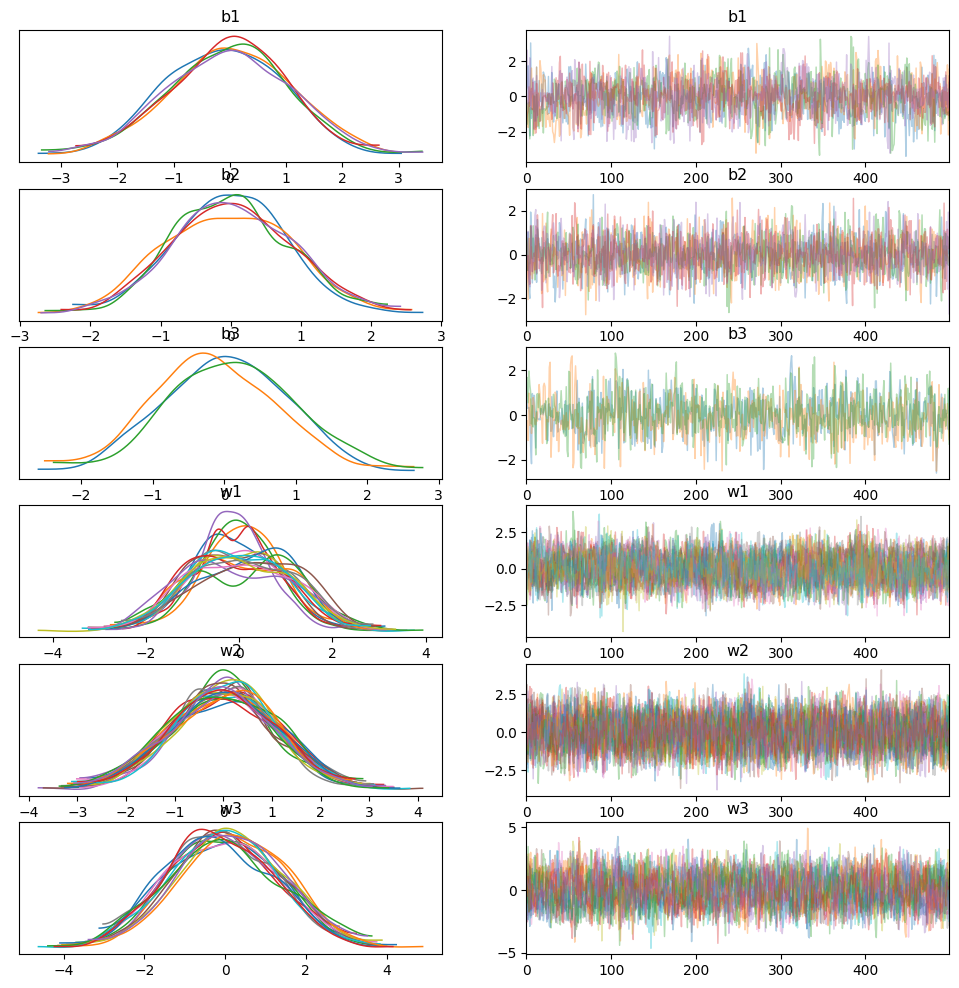

/Users/alexandroskyriakopoulos/anaconda3/envs/py313/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:233: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


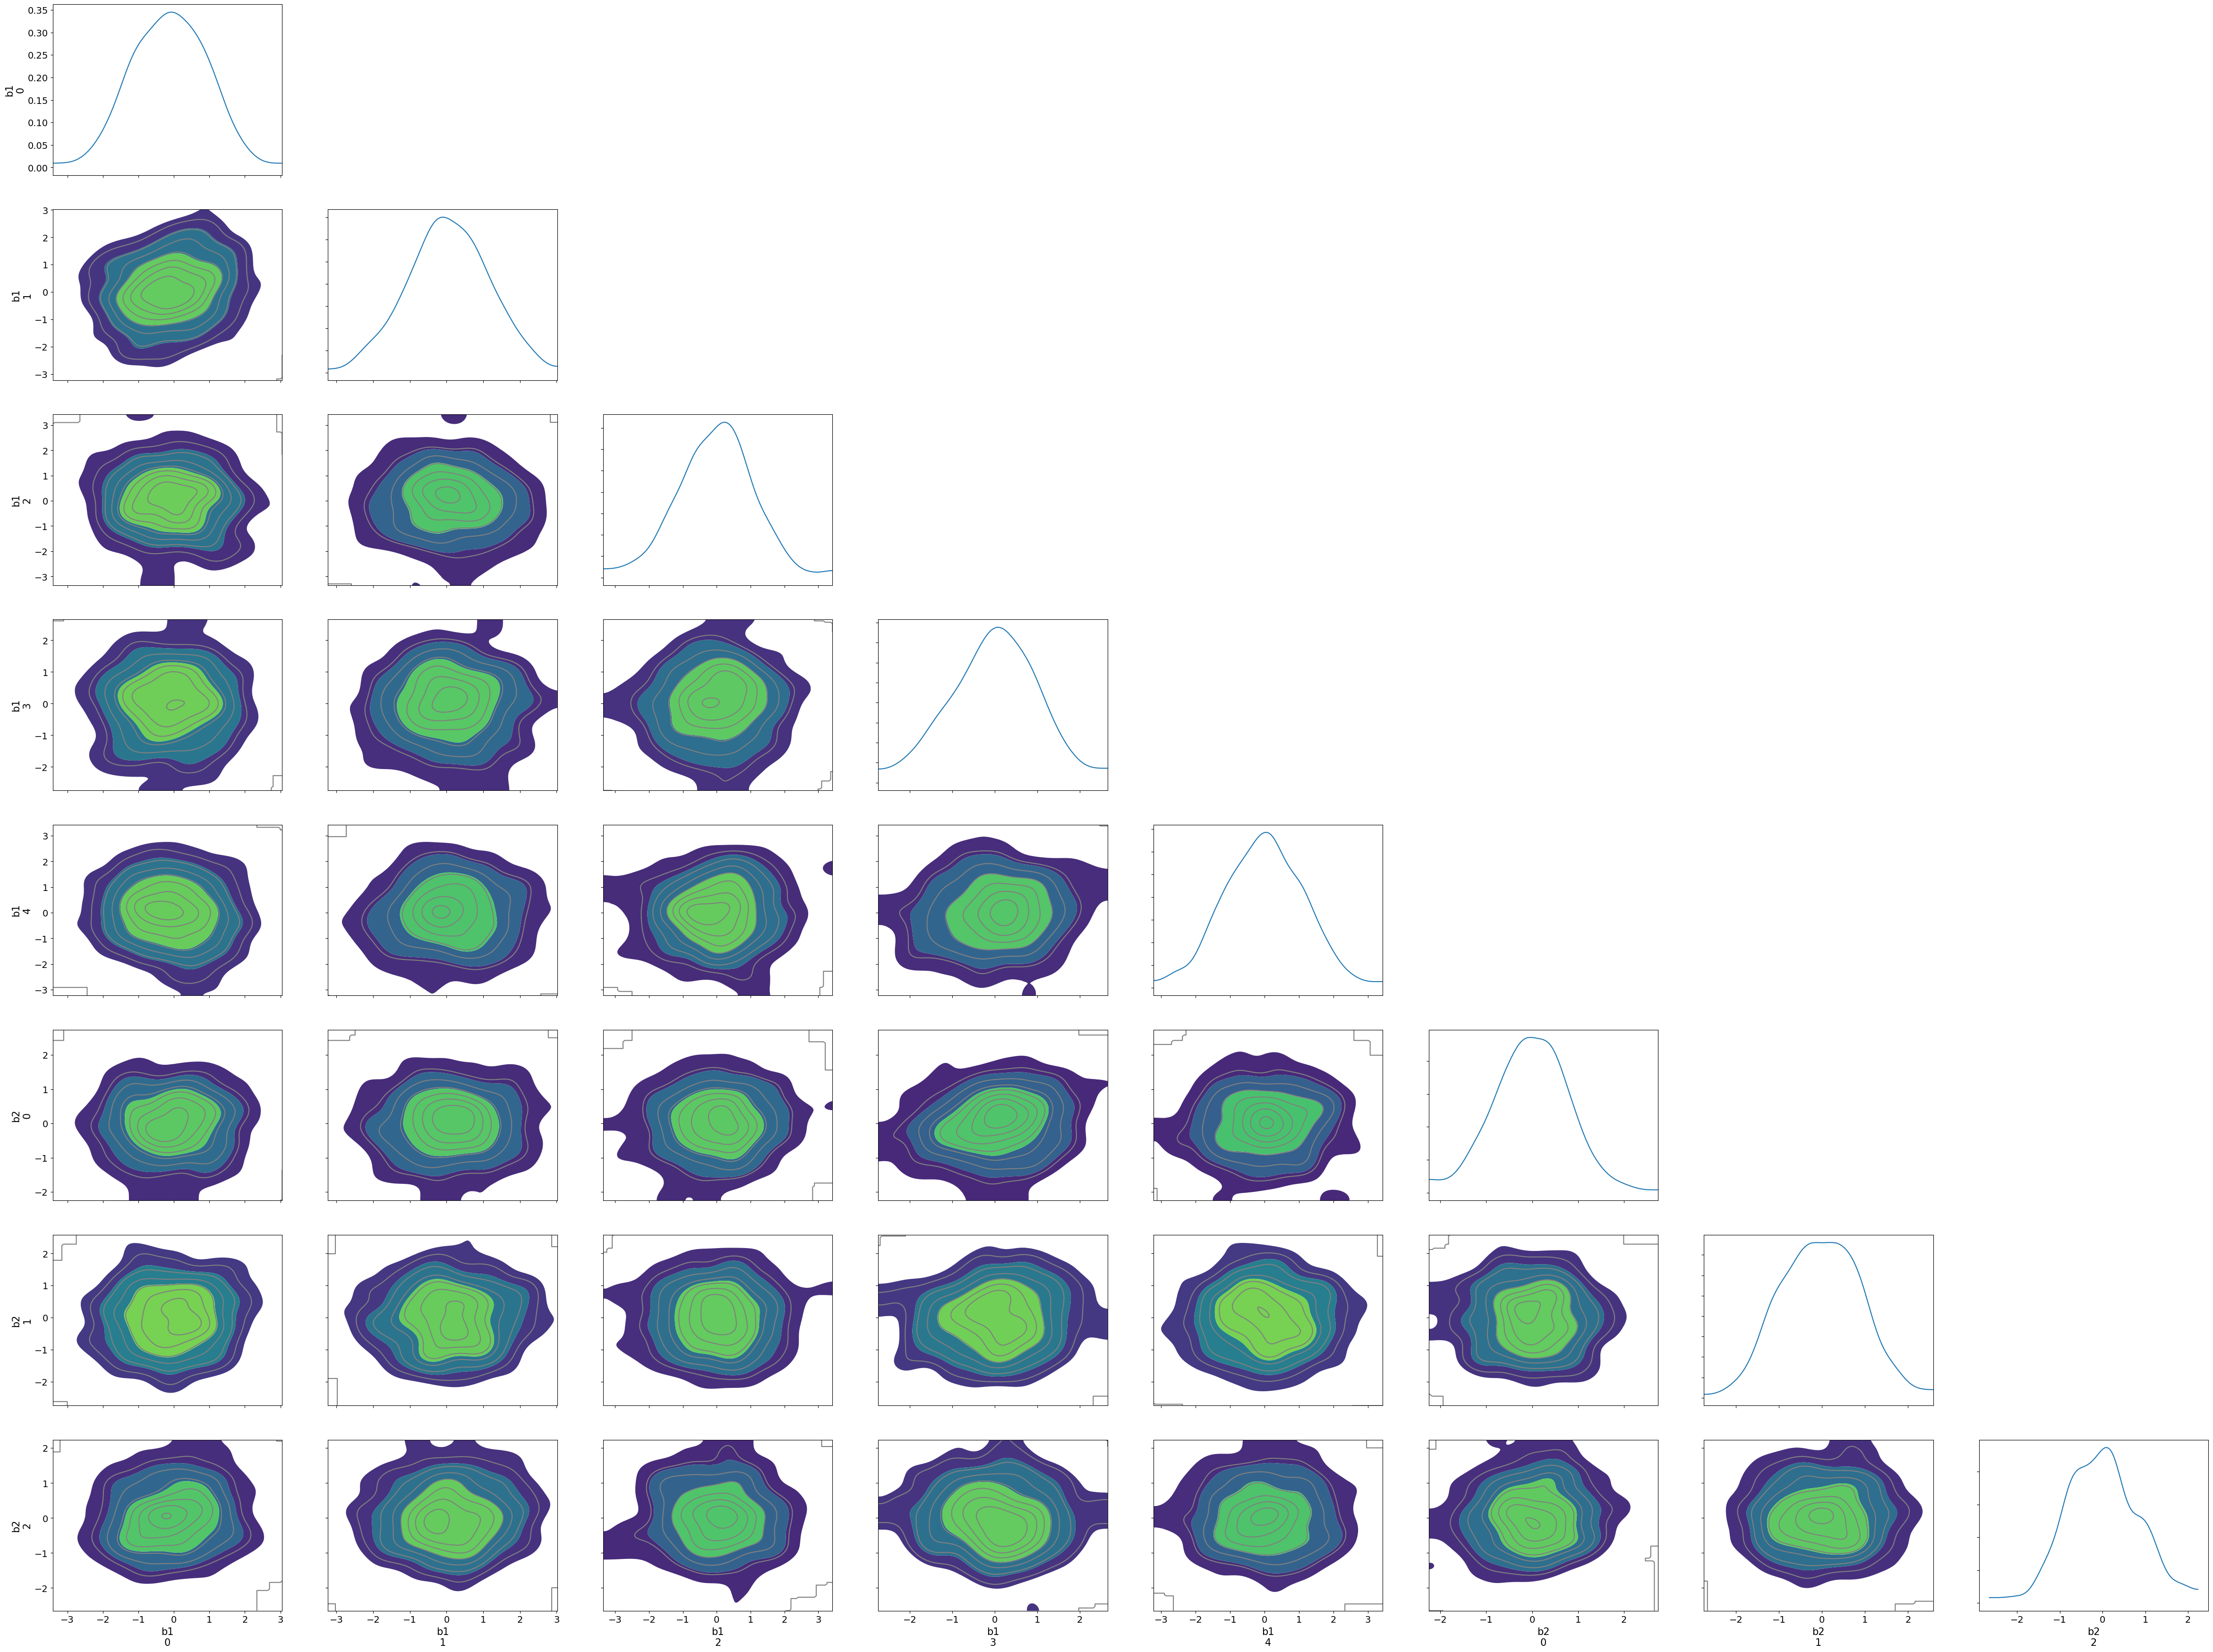

/Users/alexandroskyriakopoulos/anaconda3/envs/py313/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (73) in plot_ess, generating only 40 plots
  warnings.warn(


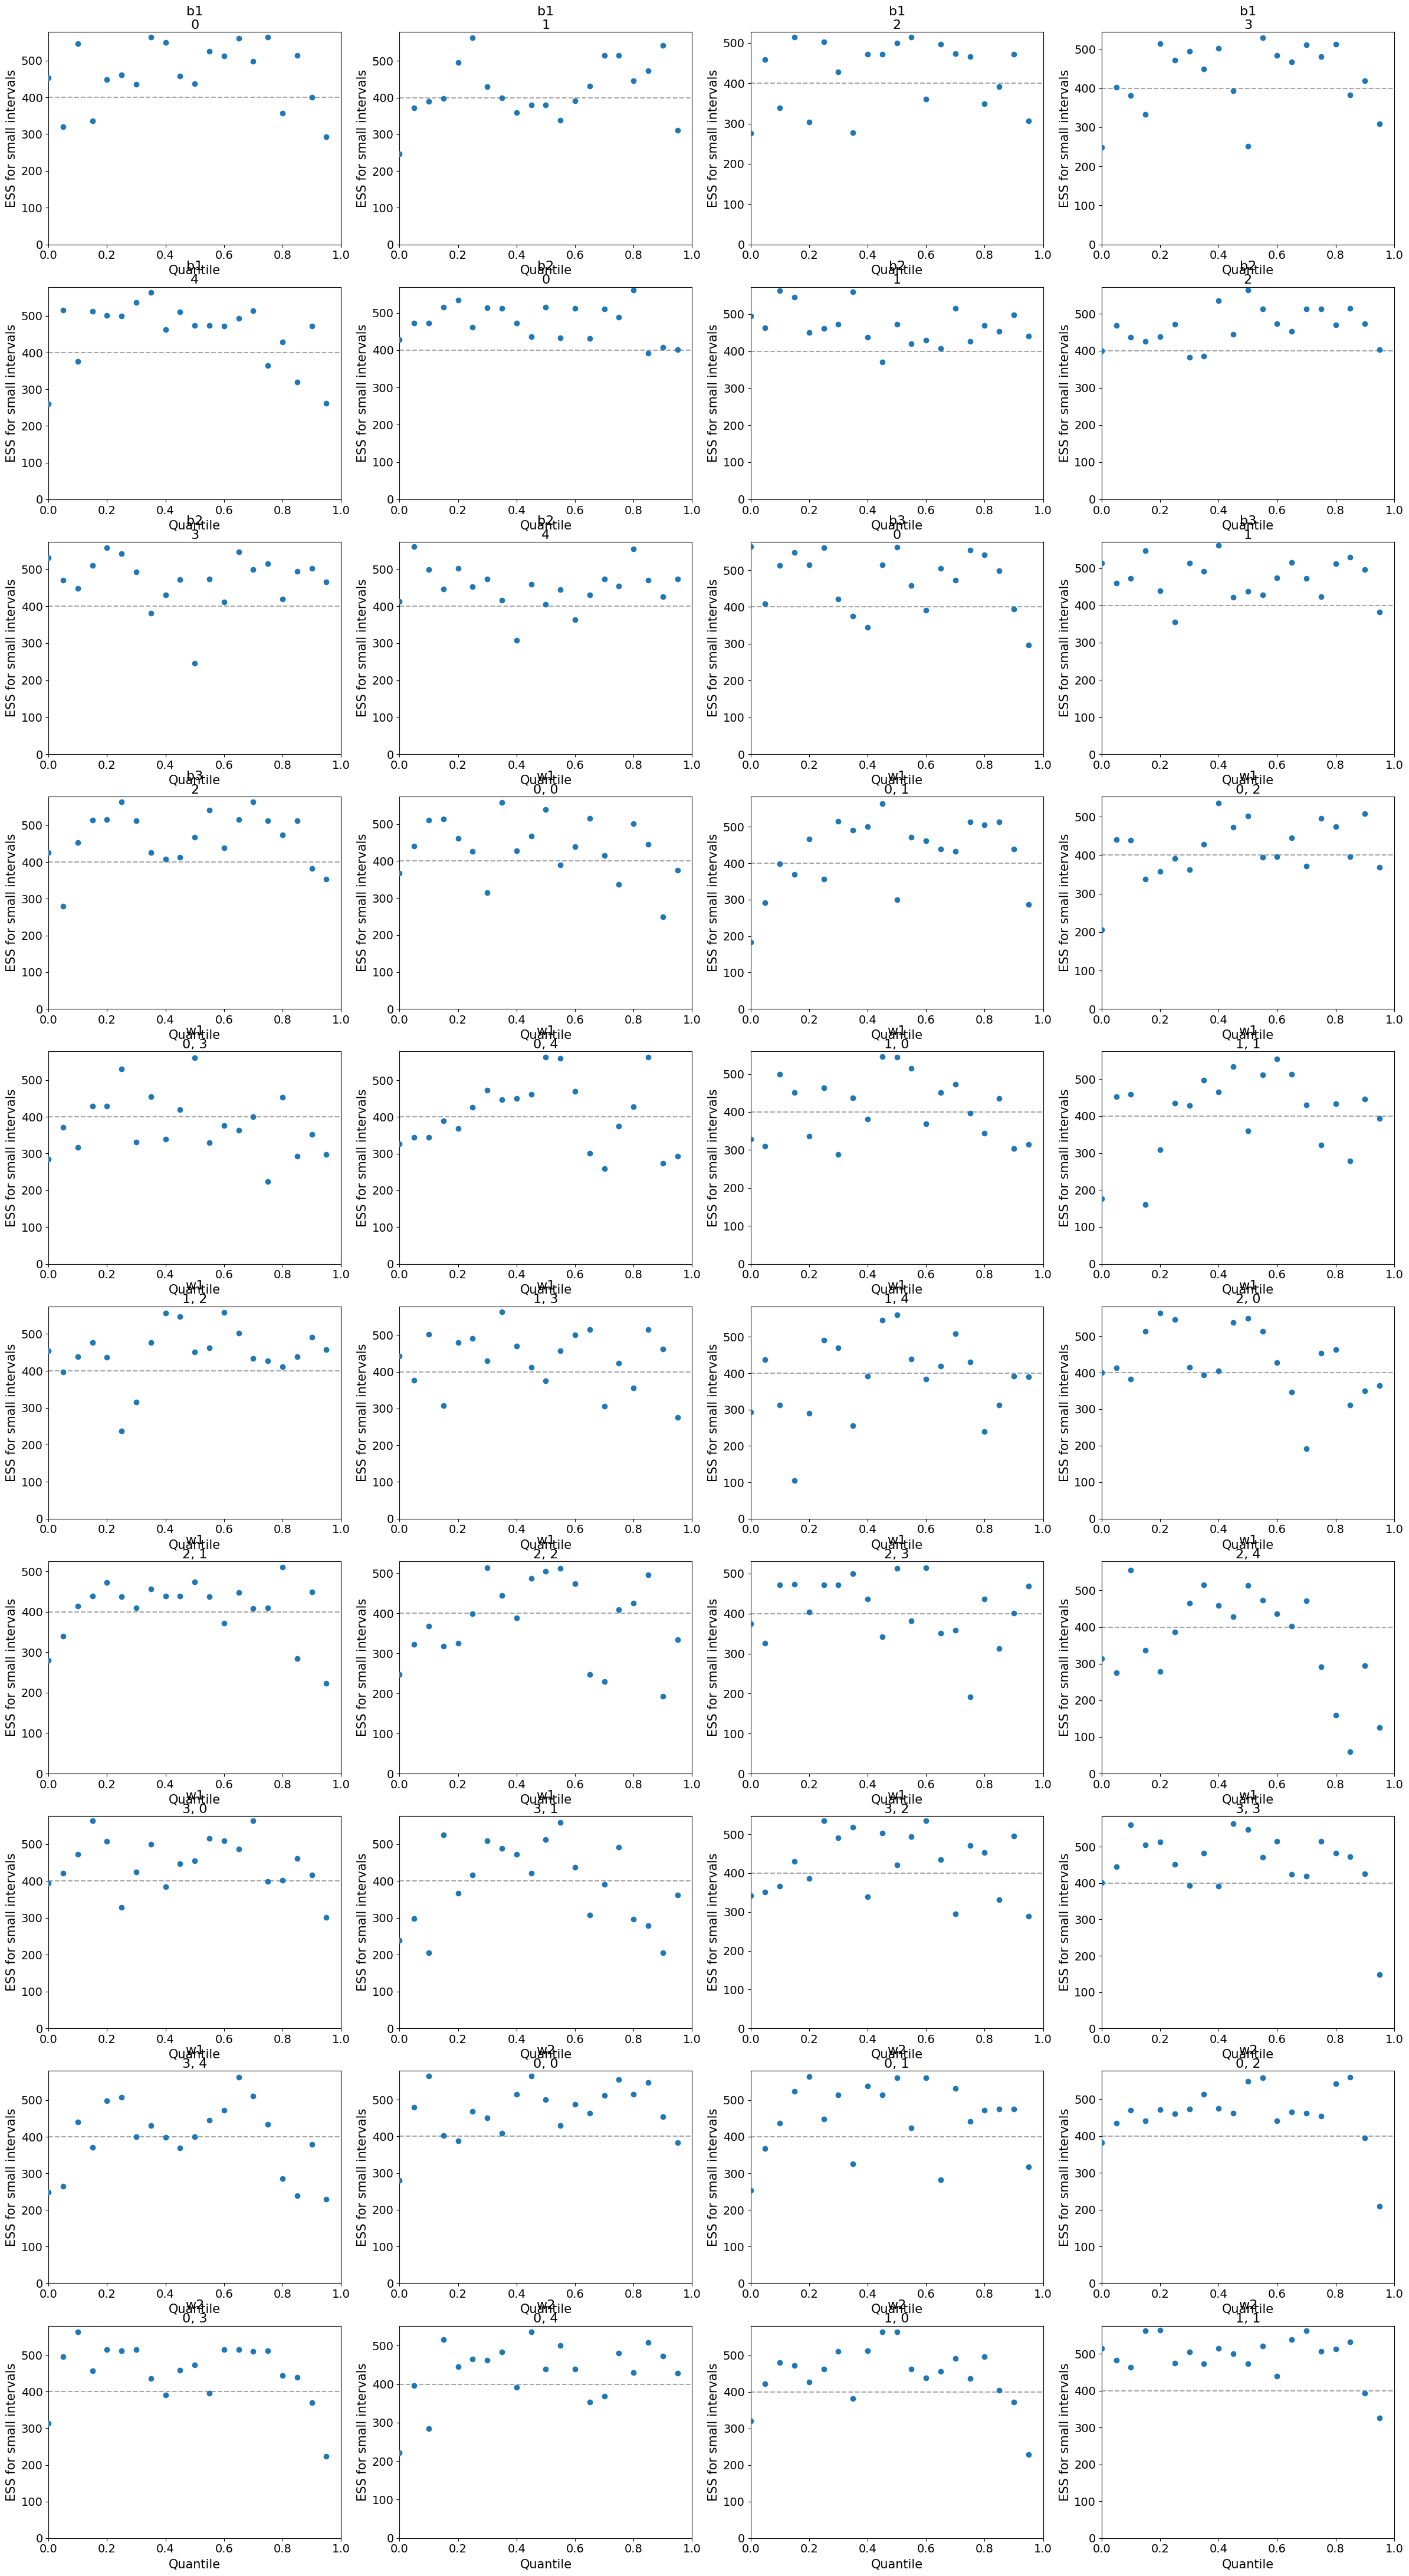

/Users/alexandroskyriakopoulos/anaconda3/envs/py313/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (73) in plot_posterior, generating only 40 plots
  warnings.warn(


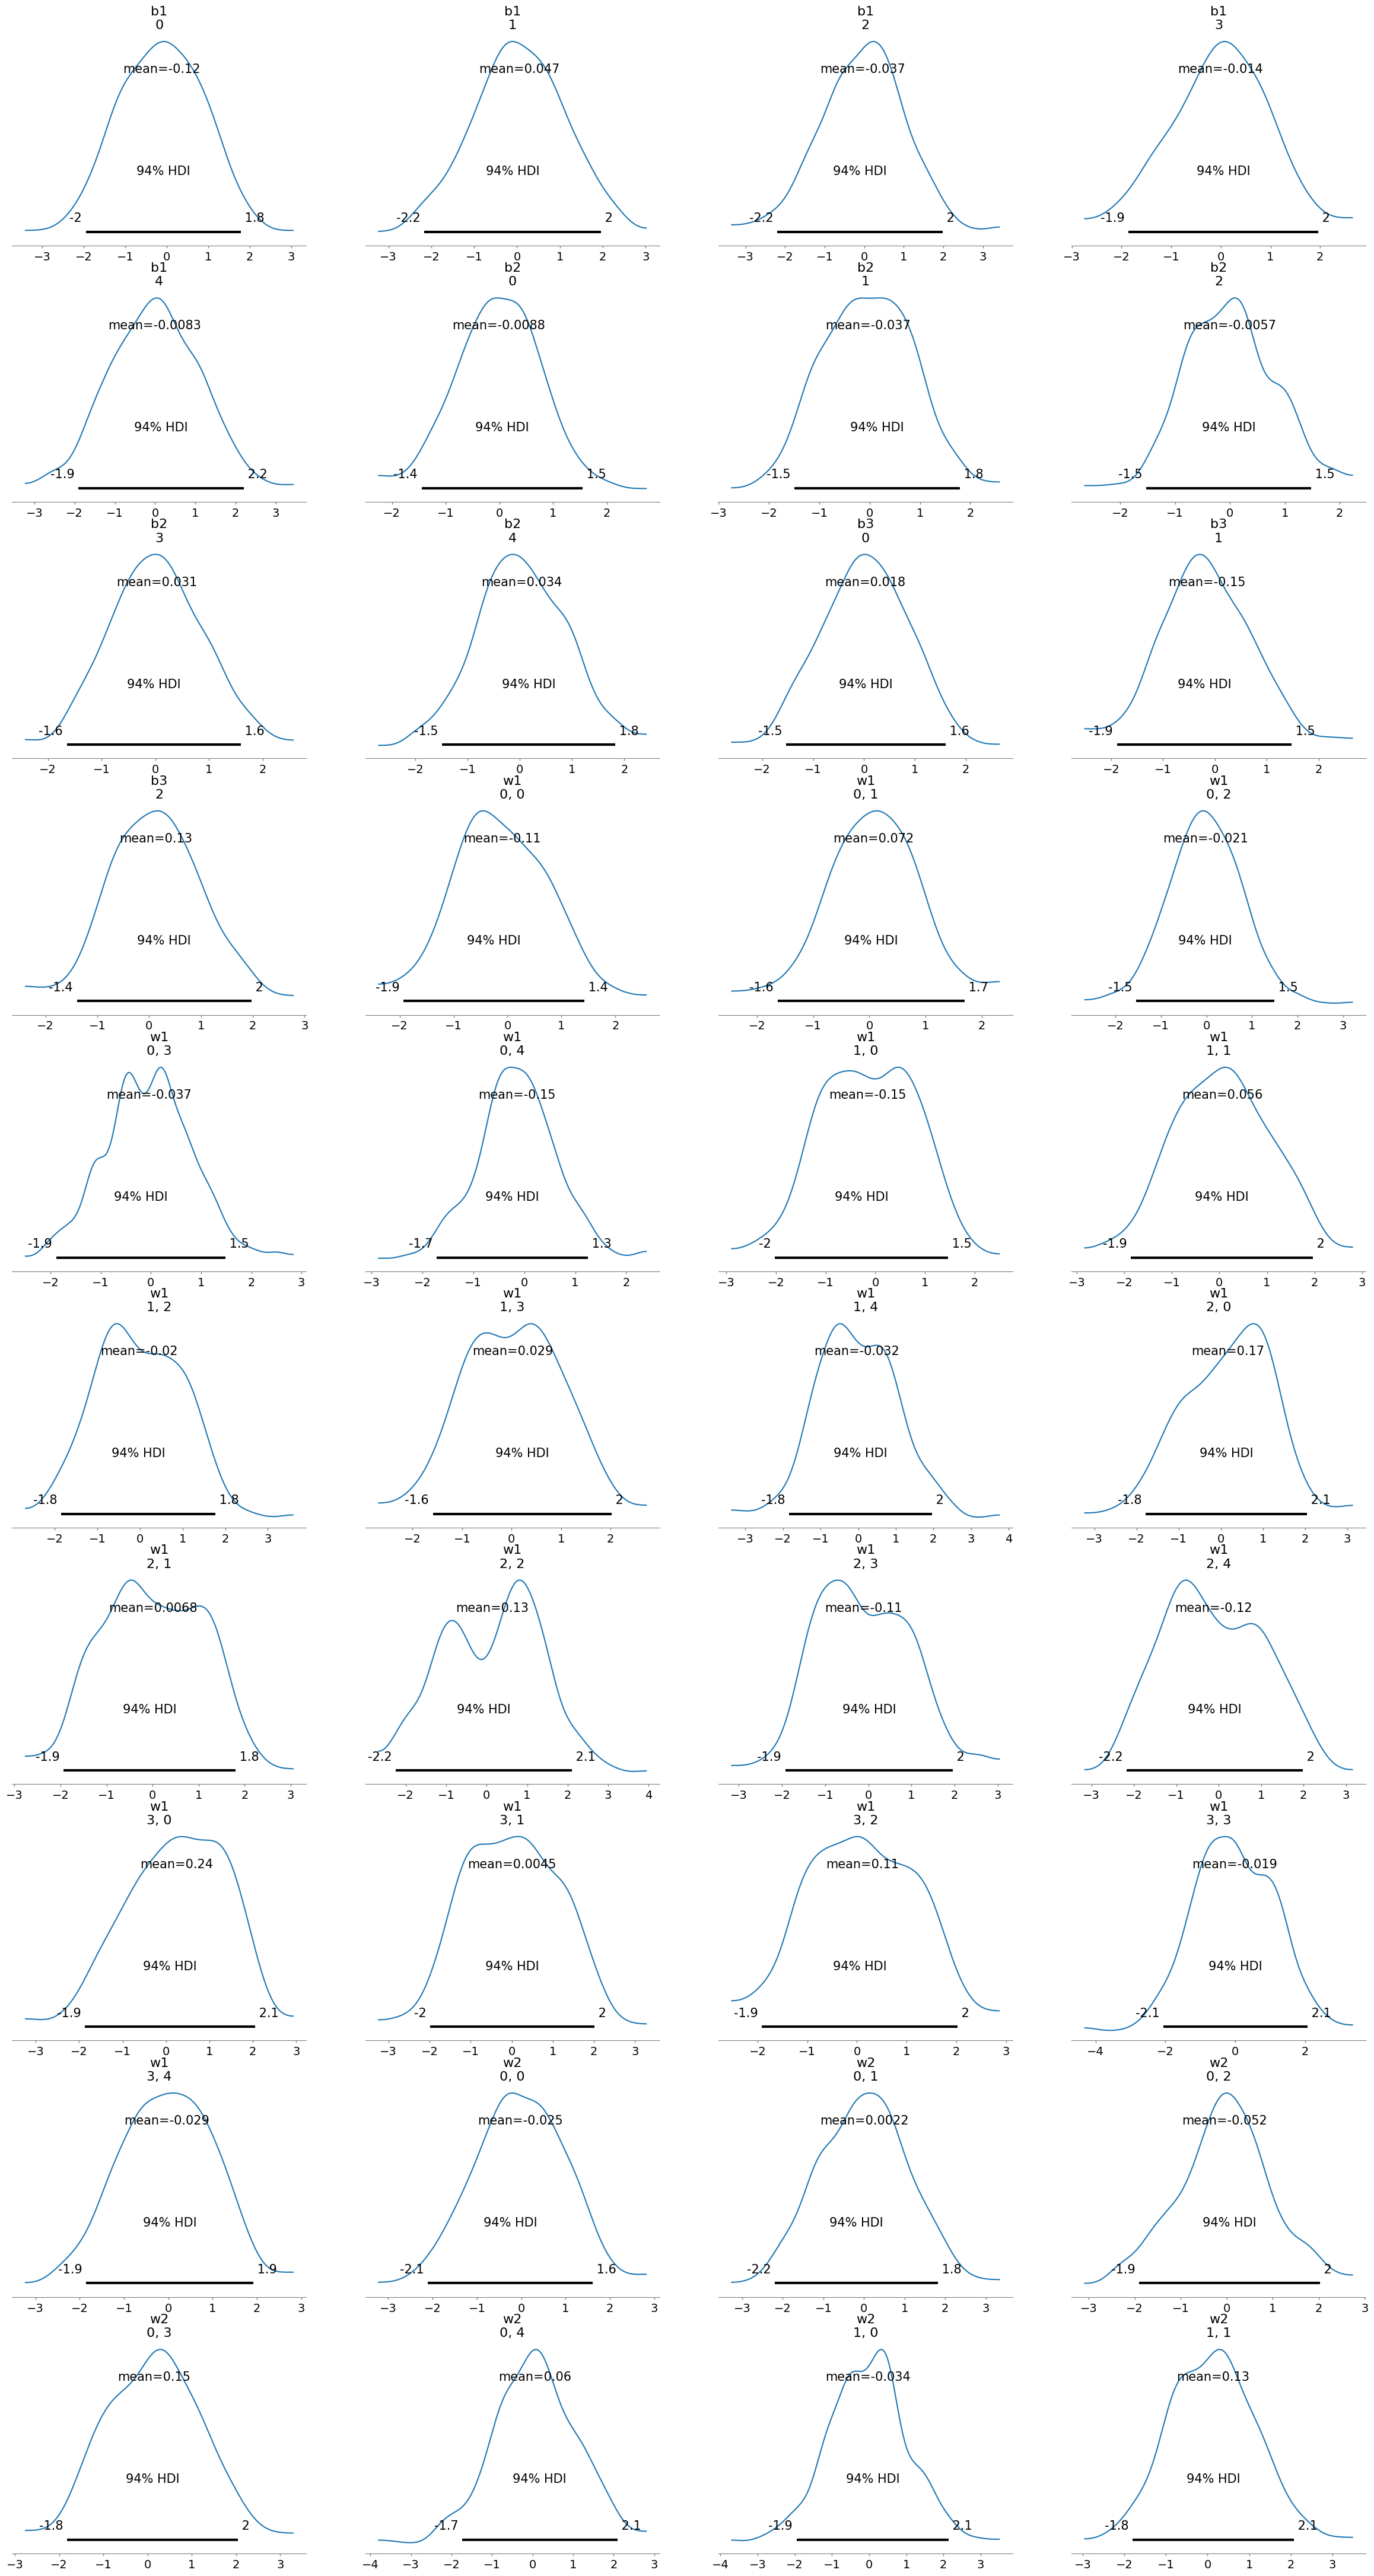

In [16]:
import arviz as az
# Convert Pyro samples to ArviZ InferenceData
idata = az.from_pyro(mcmc)

print('------------------------------Summary Statistics:-----------------------------')
summary = az.summary(idata)
print(summary)

# Trace plot to check chain mixing
az.plot_trace(idata)
plt.show()

# Pair plot to check parameter relationships
az.plot_pair(idata, kind="kde", marginals=True)
plt.show()

# Plot effective sample size (ESS)
az.plot_ess(idata)
plt.show()

az.plot_posterior(idata)
plt.show()